<img src="https://fsdl.me/logo-720-dark-horizontal">

# Lab 00: The 🥞 Full Stack 🥞 of the Text Recognizer Application

In the course of these labs,
you will build an optical character recognition (OCR) application
that is powered by a neural network:
the "FSDL Text Recognizer".

We use this application to
- demonstrate general principles for engineering an ML-powered application,
- provide a "worked example" that includes all of the juicy details, and
- introduce you to tools, libraries, and practices that we consider best-in-class or best for independent ML engineers working across the full stack.

You can try it out inside this notebook below,
or you can simply navigate to the `app_url` in your browser.

In [1]:
from IPython.display import IFrame

app_url = "https://fsdl-text-recognizer.ngrok.io/"

IFrame(app_url, width=1024, height=896)

## Frontend and Backend

What you see above is the "frontend",
the user-facing component, of the application.

Frontend web development is typically done using
Javascript as the programming language.
Most ML is done in Python (see below),
so we will instead build our frontend using
the Python library [**Gradio**](https://gradio.app/).

> <small>Another excellent choice for pure Python web development might be
[Streamlit](https://streamlit.io/)
or even, in the near future, tools built around
[PyScript](https://pyscript.net/).</small>

Notice the option to "flag" the model's outputs.
This user feedback will be sent to [**Gantry**](https://gantry.io/),
where we can monitor model performance,
generate alerts,
and do exploratory data analysis.



The model that reads the image to produce the text
is not running
in the same place as the frontend.
The model is the "backend" of our application.
We separate the two via a JSON API.
The model is deployed
[serverlessly](https://serverless-stack.com/chapters/what-is-serverless.html)
to Amazon Web Services using
[**AWS Lambda**](https://aws.amazon.com/lambda/),
which runs a
[**Docker**](https://docker-curriculum.com/)
container that wraps up our model.

> <small> Docker is the tool of choice for virtualization/containerization. As containerized applications become more complex,
[container orchestration](https://www.vmware.com/topics/glossary/content/container-management.html)
becomes important. The premier tool for orchestrating
Docker containers is
[kubernetes](https://kubernetes.io/), aka k8s.
Non-experts on cloud infrastructure will want to use their providers' managed service for k8s, e.g.
[AWS EKS](https://aws.amazon.com/eks/)
or [Google Kubernetes Engine](https://cloud.google.com/kubernetes-engine).</small>

The container image lives inside the
[Elastic Container Registry](https://aws.amazon.com/ecr/),
a sort of "GitHub for Docker" on AWS.
The choice to go serverless makes it effortless to scale up our model
across a number of orders of magnitude
and the choice to containerize reduces friction and error
when moving our model from development to production.

> <small> This could equally as well be done on another cloud,
like [Google Cloud Platform](https://cloud.google.com/)
or [Microsoft Azure](https://azure.microsoft.com/en-us/),
which offer serverless deployment via
[Google Cloud Functions](https://cloud.google.com/serverless)
and [Azure Functions](https://azure.microsoft.com/en-us/solutions/serverless),
respectively. </small>

The backend operates completely independently of the frontend,
which means it can be used in multiple contexts.

Run the cell below to send a query directly to the model on the backend.

In [2]:
import json  # JavaScript Object Notation is the lingua franca of the web

from IPython.display import Image
import requests  # requests is the preferred library for web requests in Python

lambda_url = "https://3akxma777p53w57mmdika3sflu0fvazm.lambda-url.us-west-1.on.aws/"
image_url = "https://fsdl-public-assets.s3-us-west-2.amazonaws.com/paragraphs/a01-077.png"

headers = {"Content-type": "application/json"}  # headers ensure our request is handled correctly
payload = json.dumps({"image_url": image_url})  # the request content is a string representation of JSON data

if "pred" not in locals():  # a poor man's cache: if we've defined the variable pred, skip the request
  response = requests.post(  # we POST the image to the URL, expecting a prediction as a response
      lambda_url, data=payload, headers=headers)
  pred = response.json()["pred"]  # the response is also json

print(pred)

Image(url=image_url, width=512)

And, since this is election year in West
Germany, Dr. Adenauer is in a tough
spot. Joyce Egginton cables: President
Kennedy at his Washington Press con-
ference admitted he did not know
whether America was lagging behind
Russia in missile power. He said he
was waiting for his senior military
aides to come up with the answer on
February 20.


## Application Diagram

We're only halfway through describing how the Text Recognizer works
and it's already getting hard to hold the whole thing in-memory.

Run the cell below to show a diagram that incorporates the entire
process for creating and running the Text Recognizer,
from training to feedback collection.

In [3]:
diagram_url = "https://miro.com/app/live-embed/uXjVOrOHcOg=/?moveToViewport=-1210,-1439,2575,1999"

IFrame(diagram_url, width=1024, height=512)

## Model Training

Let's start back at the beginning -- developing a model.
We'll then make our way back to where we left off above, the handoff
from model development/training
to the actual application.

We begin by training a neural network
(a [ResNet](https://pytorch.org/hub/pytorch_vision_resnet/)
encoder to process the images and 
a [Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)
decoder to produce the output text).

Neural networks operate by applying
sequences of large matrix multiplications
and other array operations.
These operations are much faster on GPUs than on CPUs
and are relatively easy to parallelize
across GPUs.
This is especially true during training,
where many inputs are processed in parallel,
or "batched" together.

Purchasing GPUs and properly setting up
a multi-GPU machine is challenging
and has high up-front costs.
So we run our training via a cloud provider,
specifically
[**Lambda Labs GPU Cloud**](https://lambdalabs.com/service/gpu-cloud).

> <small> Other cloud providers offer GPU-accelerated compute
but Lambda Labs offers it at the lowest prices,
as of August 2022.
Larger organizations may benefit from the extra features
that integration with larger cloud providers,
like AWS or GCP, can provide (e.g. unified authorization
and control planes).
Because independent, full-stack developers
are often very price-sensitive, we recommend Lambda Labs --
even more, we recommend checking current and historical instance prices.
</small>

For smaller units of work, like debugging and quick experiments,
we can use
[Google Colaboratory](https://research.google.com/colaboratory/),
which provides limited access to free GPU (and TPU)
compute in an ephemeral environment.

> <small> For small-to-medium-sized deep learning tasks,
Colab Pro (\$10/mo.) and Colab Pro+ (\$50/mo.)
can be competitive with the larger cloud providers.
</small>

If you're running this notebook on a machine with a GPU,
e.g. on Colab, running the cell below
will show some basic information on the GPU's state.

In [4]:
!nvidia-smi

Sat Aug 13 16:15:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:2D:00.0  On |                  N/A |
|  0%   47C    P8    30W / 320W |    887MiB / 10240MiB |     42%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Because the heavy work is done on the GPU,
using lower-level libraries,
we don't need to write the majority of our model development code
in a performant language like C/C++ or Rust.

We can instead write in a more comfortable, but slower language:
it doesn't make sense to drive an F1 car to the airport
for an international flight.

The language of choice for deep learning is
[**Python**](https://www.python.org/).


In [5]:
import this  # The Zen of Python

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


We don't want to write our Python library for GPU acceleration from scratch,
especially because we also need automatic differentiation --
the ability to take derivatives of our neural networks.
The Python/C++ library
[PyTorch](https://pytorch.org/)
offers GPU-accelerated array math with automatic differentiation,
plus special neural network primitives and architectures.

> <small> There are two major alternatives to PyTorch
for providing accelerated, differentiable array math,
both from Google: early mover
[TensorFlow](https://www.tensorflow.org/resources/learn-ml)
and new(ish)comer
[JAX](https://github.com/google/jax).
The former is more common in certain larger, older enterprise settings
and the latter is more common in certain bleeding-edge research settings.
We choose PyTorch to split the difference,
but can confidently recommend all three.
</small>


In [6]:
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"  # run on GPU if available

# create an array/tensor and track its gradients during calculations
a = torch.tensor([1.], requires_grad=True) \
  .to(device)  # store the array data on GPU (if available)
b = torch.tensor([2.]).to(device)

# calculate new values, building up a "compute graph"
c = a * b + a

# compute gradient of c with respect to a by "tracing the graph backwards"
g, = torch.autograd.grad(outputs=c, inputs=a)

g

tensor([3.], device='cuda:0')


PyTorch provides a number of features required for creating
deep neural networks,
but it doesn't include a high-level framework
for training or any of a number of related engineering tasks,
like metric calculation or model checkpointing.

We use the
[PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/)
library as our high-level training engineering framework.

> <small> PyTorch Lightning is the framework of choice
for generic deep learning in PyTorch,
but in natural language processing,
many people instead choose libraries from
[Hugging Face](https://hugginface.co/).
[Keras](https://keras.io/)
is the framework of choice for TensorFlow.
In some ways,
[Flax](https://github.com/google/flax)
is the same for JAX;
in others, there is not as of July 2022 a high-level
training framework in JAX.</small>

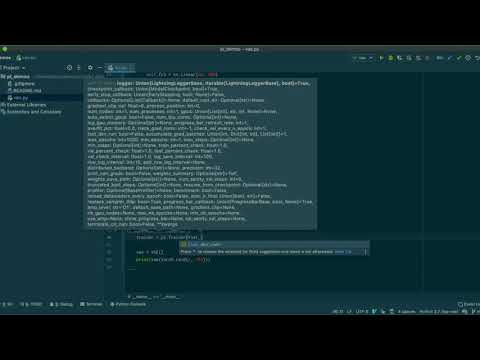

In [7]:
from IPython.display import YouTubeVideo

lit_video_id = "QHww1JH7IDU"
YouTubeVideo(lit_video_id, modestbranding=True, rel=False, width=512)

## Experiment and Artifact Tracking

ML models are challenging to debug:
their inputs and outputs are often easy for humans to interpret
but hard for traditional software programs to understand.

They are also challenging to design:
there are a number of knobs to twiddle and constants to set,
like a finicky bunch of compiler flags.
These are known as "hyperparameters".

So building an ML model often looks a bit less like engineering
and a bit more like experimentation.
These experiments need to be tracked,
as do large binary files,
or artifacts,
that are produced during those experiments
-- like model weights.

We choose
[Weights & Biases](http://docs.wandb.ai)
as our experiment and artifact tracking platform.

> <small> [MLFlow](https://github.com/mlflow/mlflow)
is an open-source library that provides similar
features to W&B, but the experiment and artifact
tracking server must be self-hosted,
which can be burdensome for the already beleaguered
full-stack ML developer.
Basic experiment tracking can also be done
using [Tensorboard](https://www.tensorflow.org/tensorboard),
and shared using [tensorboard.dev](https://tensorboard.dev/),
but Tensorboard does not provide artifact tracking.
Artifact tracking and versioning can be done using
[Git LFS](https://git-lfs.github.com/),
but storage and distribution via GitHub can be expensive
and it does not provide experiment tracking.
[Hugging Face](https://huggingface.co/) runs an alternative
git server, Hugging Face Spaces,
that can display Tensorboard experiments and
mandates Git LFS for large files (where large means >10MB).
</small>

The resulting experiment logs can be made very rich
and are invaluable for debugging
(e.g. tracking bugs through the git history)
and communicating results inside and across teams.

Run the cell below to display the logs from an experiment
that was run while designing and debugging the Text Recognizer model.

In [8]:
experiment_url = "https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/runs/lfjjnxw8"

IFrame(experiment_url, width=1024, height=768)

Logged _data_ is inert.
It becomes usable, actionable _information_
when it is given context and form.

Run the cell below to take a look at a dashboard,
built inside W&B,
reporting the results of a training run.

In [9]:
dashboard_url= "https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/reports/Training-Run-2022-06-02--VmlldzoyMTAyOTkw"

IFrame(dashboard_url, width=1024, height=768)

## The Handoff to Production

PyTorch Lightning produces large artifacts called "checkpoints"
that can be used to restart model training when it stops or is interrupted
(which allows the use of much cheaper
["preemptible" cloud instances](https://www.determined.ai/blog/scale-your-model-development-on-a-budget)).

We store these artifacts on Weights & Biases.

When they are ready to be deployed to production,
we compile these model checkpoints down to a dialect of Torch called
[torchscript](https://pytorch.org/docs/stable/jit.html)
that is more portable:
it drops the training engineering code
and produces an artifact that is executable in C++ or in Python.
We stick with a Python environment for simplicity.

> <small> TensorFlow has similar facilities
for delivering models, including
[tensorflow.js](https://www.tensorflow.org/js)
and [TensorFlow Extended (TFX)](https://www.tensorflow.org/tfx).
There are also a number of alternative portable runtime environments
for ML models, including
[ONNX RT](https://onnx.ai/).</small>

These deployable models are also stored on Weights & Biases,
which connects them to rich metadata,
including the experiments and training runs
that produced the checkpoints from which they were derived.

Run the cell below to review the metadata for a deployable
version of the Text Recognizer model.

In [10]:
artifact_url = "https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/artifacts/prod-ready/paragraph-text-recognizer/v8"

IFrame(artifact_url, width=1024, height=768)

We can pull this file down,
package it into a Docker container
via a small Python script,
and ship it off to a container registry, like AWS ECR or Docker Hub, so that
it can be used to provide the backend to our application.

## Application Diagram, Redux

Now that we have made it through the
🥞 full stack 🥞 of the Text Recognizer application,
let's take a look at the application diagram again.

In [11]:
IFrame(diagram_url, width=1024, height=512)

Over the remainder of the labs,
we will put all of these pieces together,
learning more about the problems they solve,
the tradeoffs they make,
and how they are best used.